# LTR Figure Generation for Workflow and Sampling Methods

This notebook is used to generate several of the figures in Salinas and Chmielewski (2023). Figures are currently limited to those discussed in detail in Salinas and Chmielewski (2023) which include OK-0621 and OK-1021. However, if desired, users may modify to plot data from other tracked linear storms.

    -) The figures include the LTR example using 3 different time intervals for constructing the FEDs.
    -) Plotting the Otsu's threshold values a user defined instance of time for all 3 time intervals for OK-0621
    -) Flash Rate variability
    -) FED variability (3d)
    -) Consolidated max flash rate figure statistical plot + time-to-space figure.


Figures comparing and evaluating the LTR across cases and time intervals are generated in Compare-Evaluate.ipynb. For comments or questions contact: vicente.salinas@noaa.gov

In [1]:
%matplotlib inline
#Basic imports
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata

#Function calls for map projections and Figure Plotting
import backend as bk
import PlottingFunctions as plots

#Ignore any and all deprecation warnings to declutter cell outputs
import warnings
warnings.filterwarnings("ignore")

Read in Case Param File:
--------

For a single case, open the case param file to get the map projection functions for the OKLMA cases (OK-0621 and OK-1021). Then open all case FED grids, ellipse data, and sampling grid files for 1, 5, 10 minute time intervals that are provided in this notebook. Note: this notebook is only to be used to reproduce figures in the paper. Modification of the cell in this notebook is required if new cases are to be added.

In [2]:
#-----------------------------------
#Read in gridding parameters--shared 
#across GLM and LMA gridding routines:
#-----------------------------------
set_dt      = '1min' #REDO 1min and use better gauss smoothing to smooth centroids! Based on factor diff from previous 10min->5min->1min or 1->2->5!
set_case    = '20210612' #YYYYMMDD
target      = f'CaseParams/{set_dt}/FlashGriddingParams_{set_case}.txt'
params      = eval(open(target, 'r').read())
case        = params['Case']
network     = params['network']
network_lon = params['network_lon']
network_lat = params['network_lat']
#Generate reference for map projection relative to OKLMA network center:
geo,proj,(clon,clat) = bk.LMA_projection(network,network_lat,network_lon)

In [3]:
#Set list of directory names for the time interval sused for the OKLMA cases.
#--------------------------------------
dts  = ['1min','5min','10min'] #grids with different time frames

In [4]:
#Read lma grid files + tracking geometry and grid:
#---------------------------------------
#Open FED gridded data
lma_1min      = xr.open_dataset(f'LightningData/LMA/gridded/{dts[0]}/OKLMA_GRIDS_{case[2:]}_{dts[0]}.nc')
lma_5min      = xr.open_dataset(f'LightningData/LMA/gridded/{dts[1]}/OKLMA_GRIDS_{case[2:]}_{dts[1]}.nc')
lma_10min     = xr.open_dataset(f'LightningData/LMA/gridded/{dts[2]}/OKLMA_GRIDS_{case[2:]}_{dts[2]}.nc')
#Open ellipse data
ellipse1min   = xr.open_dataset(f'Output/{dts[0]}/TrackedData/{case[2:]}/{case}_Tracked_Ellipse_Verts.nc')
ellipse5min   = xr.open_dataset(f'Output/{dts[1]}/TrackedData/{case[2:]}/{case}_Tracked_Ellipse_Verts.nc')
ellipse10min  = xr.open_dataset(f'Output/{dts[2]}/TrackedData/{case[2:]}/{case}_Tracked_Ellipse_Verts.nc')
#Open sampling grid data
grid1min      = xr.open_dataset(f'Output/{dts[0]}/TrackedData/{case[2:]}/{case[2:]}_sample_grid_dx10.nc')
grid5min      = xr.open_dataset(f'Output/{dts[1]}/TrackedData/{case[2:]}/{case[2:]}_sample_grid_dx10.nc')
grid10min     = xr.open_dataset(f'Output/{dts[2]}/TrackedData/{case[2:]}/{case[2:]}_sample_grid_dx10.nc')

In [5]:
#Get relevent fields:
#-----------------------------------------
#FED Field
fed_1min  = lma_1min.flash_extent_density .values
fed_5min  = lma_5min.flash_extent_density .values
fed_10min = lma_10min.flash_extent_density.values
#Geographic Coordinates
lon       = lma_1min.grid_longitude.values
lat       = lma_1min.grid_latitude .values
#Generate meshgrid
lonM,latM = np.meshgrid(lon,lat)

## Transform Sample Grid Coordinates
---
Tranform the sample grid coordinates to geographic coordinates for generating a mapped figure of the LTR methodology.

In [6]:
#Define function to handle coordinate transformations so repeated lines of code are not needed (declutter):
#-----------------------------------------
get_lonlats = plots.get_lonlats

In [7]:
#Transform FED grid geographic coordinates to cartesian relative to OKLMA center
#-----------------------------------------
ecefx,ecefy,ecefz = geo.toECEF(lonM.flatten(),latM.flatten(),lonM.flatten()*0)
px,py,pz          = proj.fromECEF(ecefx,ecefy,ecefz)
px,py,pz          = px.reshape(lonM.shape), py.reshape(lonM.shape), pz.reshape(lonM.shape)

#Define sample grid coordinate variables for easy manipulation in other functions-->change to units meters
#-----------------------------------------
#This step will take a little while depending on how many time frames there are in the higher time resolution grids.
g1_vx,g1_vy   = grid1min .sample_line[:,:,:,0].values *1e3,grid1min .sample_line[:,:,:,1].values *1e3
g5_vx,g5_vy   = grid5min .sample_line[:,:,:,0].values *1e3,grid5min .sample_line[:,:,:,1].values *1e3
g10_vx,g10_vy = grid10min.sample_line[:,:,:,0].values *1e3,grid10min.sample_line[:,:,:,1].values *1e3

#Transform all sampling grid coordinates to geographic coordinates for generating the LTR examle figure overlaid onto 
#projected map:
#-----------------------------------------
g1_xcoords,g1_ycoords,g1_zcoords    = get_lonlats(g1_vx.flatten(),
                                                  g1_vy.flatten(),
                                                  g1_vx.flatten()*0,geo,proj)
print('1min coords done.')  
g5_xcoords,g5_ycoords,g5_zcoords    = get_lonlats(g5_vx.flatten(),
                                                  g5_vy.flatten(),
                                                  g5_vx.flatten()*0,geo,proj)
print('5min coords done.')
g10_xcoords,g10_ycoords,g10_zcoords = get_lonlats(g10_vx.flatten(),
                                                  g10_vy.flatten(),
                                                  g10_vx.flatten()*0,geo,proj)
print('10min coords done.')

1min coords done.
5min coords done.
10min coords done.


In [8]:
#Reshape coordinate arrays to match that of the original grid
#-----------------------------------------
g1_xcoords, g1_ycoords  = g1_xcoords .reshape(grid1min .sample_line[:,:,:,0].shape),g1_ycoords .reshape(grid1min .sample_line[:,:,:,0].shape)
print('1 min grid reshaped.')
g5_xcoords, g5_ycoords  = g5_xcoords .reshape(grid5min .sample_line[:,:,:,0].shape),g5_ycoords .reshape(grid5min .sample_line[:,:,:,0].shape)
print('5 min grid reshaped.')
g10_xcoords,g10_ycoords = g10_xcoords.reshape(grid10min.sample_line[:,:,:,0].shape),g10_ycoords.reshape(grid10min.sample_line[:,:,:,0].shape)
print('10 min grid reshaped.')

1 min grid reshaped.
5 min grid reshaped.
10 min grid reshaped.


## Transform Ellipse Coordinates:
------
Now transform the ellipse boundary (vertices) coordinate from cartesian to geographic for overlaying onto the LTR methodology figure.

In [9]:
#Set variable names for 1, 5, and 10 minute x and y boundary coordinates for all tracked ellipses:
#-----------------------------------------
#Set variable names for x and y boundary coordinates
e1_vx,e1_vy   = ellipse1min.ellipse_x .values *1e3,ellipse1min.ellipse_y .values *1e3
e5_vx,e5_vy   = ellipse5min.ellipse_x .values *1e3,ellipse5min.ellipse_y .values *1e3
e10_vx,e10_vy = ellipse10min.ellipse_x.values *1e3,ellipse10min.ellipse_y.values *1e3

#Now transform coordinates from cartesian to geographic:
e1_xcoord,e1_ycoord,_   =get_lonlats(e1_vx.flatten() ,e1_vy .flatten()  ,e1_vy.flatten() *0,geo,proj)
print('1min coords done.')  
e5_xcoord,e5_ycoord,_   =get_lonlats(e5_vx.flatten() ,e5_vy .flatten()  ,e5_vy.flatten() *0,geo,proj)
print('5min coords done.')  
e10_xcoord,e10_ycoord,_ =get_lonlats(e10_vx.flatten(),e10_vy.flatten()  ,e10_vy.flatten()*0,geo,proj)
print('10min coords done.')  

1min coords done.
5min coords done.
10min coords done.


In [10]:
#Reshape coordinate arrays to match original if result was > 2D
#-----------------------------------------
e1_xcoord,e1_ycoord   = e1_xcoord.reshape(ellipse1min.ellipse_x  .shape),e1_ycoord.reshape(ellipse1min.ellipse_x  .shape)
print('1 min coordinates reshaped.')
e5_xcoord,e5_ycoord   = e5_xcoord.reshape(ellipse5min.ellipse_x  .shape),e5_ycoord.reshape(ellipse5min.ellipse_x  .shape)
print('5 min coordinates reshaped.')
e10_xcoord,e10_ycoord = e10_xcoord.reshape(ellipse10min.ellipse_x.shape),e10_ycoord.reshape(ellipse10min.ellipse_x.shape)
print('10 min coordinates reshaped.')

1 min coordinates reshaped.
5 min coordinates reshaped.
10 min coordinates reshaped.


# Plot LTR Methodology Figure:

The figure plotting code does the following:

    1) Defines the sample axis for each case as the 50th point (if using 100 sample points) along each sample segment. This is handled by the variable "half",
    2) Set indices for user selected time frames. Because the time indices will not line up for low-to-high time resolutions, find the indices that get the closest matching time frames. Here index 100, 20 , and 10 are used to define the exact same time (UTC) for each FED grid generated using 1, 5, and 10 min intervals, respectively. These correspond to variables "idx_1min, idx_5min, and idx_10min",
    3) First row of figures illustrates the FED at each time interval (for selected time frame),
    4) Second row of figures illustrate the smoothed FED as defined by applying a 2D Gaussian filter with varying neighborhood sizes of 10, 5, and 5 pixels for 1, 5, and 10 minute time intervals, respectively.
    5) Third row, Draw tracking ellipse geometry over FED with sample axis and points overlaid and segment numbers annotated,
    6) Fourth row, Draw sample grids as small points. Similar to third row but with the addition of the full sample grid point data.
    
Note: Figure does not include the image dilation and erosion steps as these are calculated in sequence by the backend functionality.

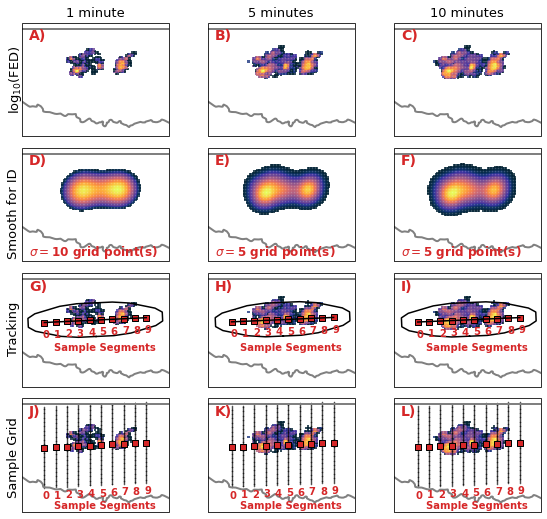

In [11]:
#Define sample axis as the midpoints along each sample segment:
#-----------------------------------------
half = int(g1_xcoords.shape[0]/2)
f1,f5,f10 = plots.ltr_method(half,lon,lat,
                             fed_1min   ,fed_5min ,fed_10min,
                             e1_xcoord  ,e1_ycoord,
                             e5_xcoord  ,e5_ycoord,
                             e10_xcoord ,e10_ycoord,
                             g1_xcoords ,g1_ycoords,
                             g5_xcoords ,g5_ycoords,
                             g10_xcoords,g10_ycoords,save=False)

# Plot Otsu's Method Example Figures:

An example of the utility of Otsu's method for thresholding is plotted. Only a single time frame is selected and matches those shown in the LTR methodology figure and only for OK-0621. Otsu's method provides an adaptive way to threshold FED data without having to set a static threshodl which may not match from time-frame to time-frame. This figure demonstrates its utility by illustrating how it determines the cutoff point bewteen the desired feature to be identified and all other pixels on the FED grid that are not to be utlized for tracking.

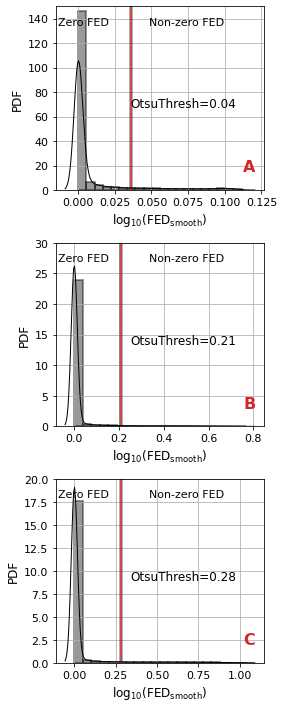

In [12]:
plots.otsu_plots_gen(f1,f5,f10,False)

# Sampling Method Figures:
---------
Here, three figures are generated to exemplify the use of the sampling grid for visualizing the variability of the total flash rates through each sample segment, FED variability through a linear storm system's length (longest axis) in 3D, and a figure that consolidates sample segment flash rates in space and time, and uses the sample axis to generate a space-to-time conversion image illusrating the flash rate evolution as a storm moves through the analysis domain.

Only FED data are used for the 3D sample grid cross-section figure, and both OK-0621 and OK-1021 are used for the consolidate flash rate statistics figure and sample-segment flash rate figure.

## Sample-segment Flash Rate Variability:
Using the provided flash sorted LMA data (quality-controlled using typical filter parameters), sample the flash rates along each sample segment and plot them agains the storm total flash rate. 

This figure exemplifies the utility of the LTR and sampling grid in documenting through-length and width variability in the electrical activity of linear storm systems. The cells below are commented to provide step-by-step details of their purpose.

In [13]:
#Get data chunks using a specified FED grid time-delta:
#------------------------------
set_dt = '5min' #Can change selection, we use 5 since its between the 3 intervals used
data1 = xr.open_dataset(f'LightningData/LMA/sorted/2021-06-12-OKLMA_SAMPLED.nc')#plots.get_data('20210612',set_dt)
data2 = xr.open_dataset(f'LightningData/LMA/sorted/2021-10-27-OKLMA_SAMPLED.nc')#plots.get_data('20211027',set_dt)

### Here, we use the sampling grids to sample the data thus providing per-segment flash rates

In [14]:
#Set sample point buffer size to collect flashes initiating within x km from each point:
#------------------------------
buffer = 10 #km

In [15]:
samps1 = plots.get_samples(buffer,'20210612') #ok0621 (data1,buffer)
samps2 = plots.get_samples(buffer,'20211027') #ok1021 (data2,buffer)

In [16]:
#This quick method computes the time bounds to generate histograms to compute the total flash rates
#------------------------------
#OK-0621 total flash rate time bounds
tbounds1     = np.zeros(data1.frames.values.shape[0]+1)
tbounds1[:len(data1.frames.values)] = data1.frames.values
tbounds1[-1] = data1.frames.values[-1]+300
#OK-1027 total flash rate time bounds
tbounds2     = np.zeros(data2.frames.values.shape[0]+1)
tbounds2[:len(data2.frames.values)] = data2.frames.values
tbounds2[-1] = data2.frames.values[-1]+300

#Calculate histograms and total flash rate and bin centeres for plotting
#OK-0621
total1 = np.histogram(np.hstack(data1.lma_time.values),bins=tbounds1)
tc1    = (total1[1][1:]+total1[1][:-1])/2
#OK-1027
total2 = np.histogram(np.hstack(data2.lma_time.values),bins=tbounds2)
tc2    = (total2[1][1:]+total2[1][:-1])/2

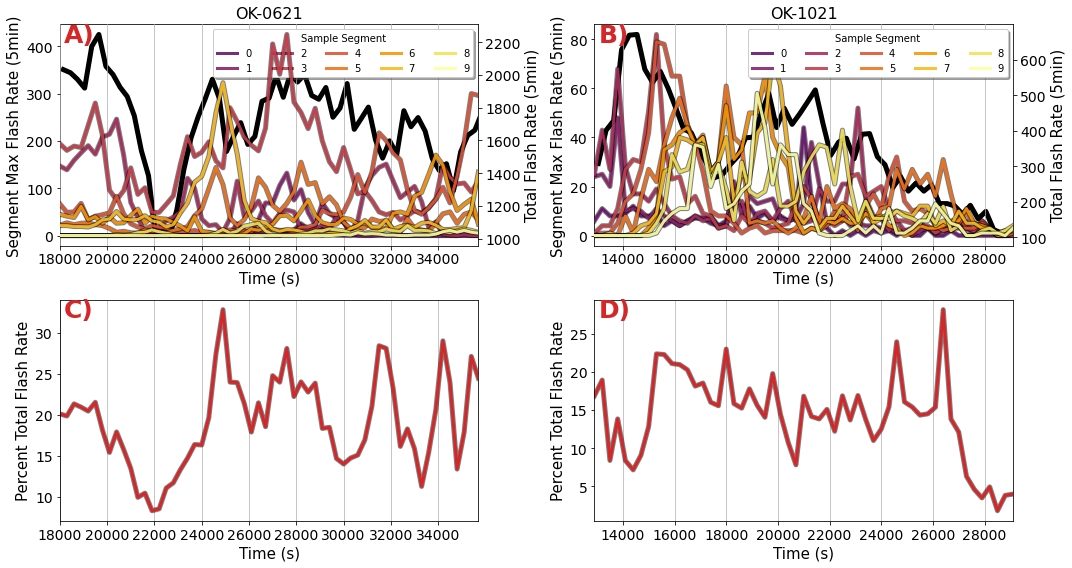

In [17]:
#Plot the sample segment flash rates
#------------------------------
idx_5min=20
plots.plot_seg_fr(data1,samps1,data2,samps2,total1,total2,tc1,tc2,idx_5min,False)

## 3D FED Variability:

Here we demonstrate the utility of the LTR sampling grid in generating cross-sections from 3D FED datasets. The purpose of this figure is to exemplify the variation in lightning-activity structure through the length of a linear storm system, and how in comparison to examining bulk flash statistics, visualizing local lightning activity is also important in isolating features that would otherwise be lost to a more aggregated depiction. 

The figure generated illustrates 2D vertical cross-sections for a single time frame of OK-0621. The aggregated FED (mean through length-axis) is shown on the farthest 'wall' of the figure to illusrate how each segment draws equally important features that may be hidden by a generalized field alone. Flash rate trends are overlaid above each cross-section simply to illustrate how these fields can also be used to compare through-length variability of flash activity. Suggested time-intervals are already set for generating the figure used in the manuscript.

### Below is an excerpt of the code used to accomplish this interpolation using the actual 3D FED gridded data--omitted due to file size.

```
grids5min1 = xr.open_dataset(f'LightningData/LMA/gridded/5min/OKLMA_GRIDS_210612_5min_3d.nc')

tframes = grids5min1.flash_extent_density.shape[0]
glons   = grids5min1.grid_longitude.values
glats   = grids5min1.grid_latitude.values
galts   = grids5min1.grid_altitude.values
field   = grids5min1.flash_extent_density.values
sampling= data1.samp_grid.values
tx,ty = np.meshgrid(np.linspace(0,100,100),galts)
```

```
samps = plots.fed_interp(tframes,field,glons,glats,galts,sampling,35,36,geo,proj,'nearest')
```

### Here, use the pre-sampled data:

In [18]:
sampled_fed = xr.open_dataset(f'LightningData/LMA/gridded/5min/OKLMA_GRIDS_210612_5min_3d-SAMPLED.nc')
samps       = sampled_fed.flash_extent_density.values
alts        = sampled_fed.altitude.values
tx,ty       = np.meshgrid(np.arange(100),alts)

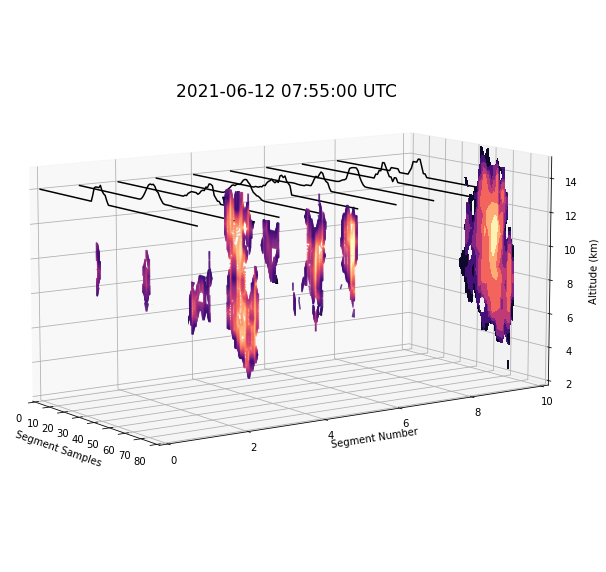

In [19]:
plots.samples_3d(tx,ty,samps1,samps,35,False)

## Space-Time Figures
Here we demonstrate how LTR sampling analyses can be consolidated to directly compare how flash rates vary with time and through the storm system length for both OKLMA cases. In addition, a space-time figure is generated to show the progression of the flash activity evolution (in space and time) where flash rates were sampled. 

The figures generated demonstrate the utility of the LTR in illustrating and quantifying through-storm flash rate variability in both space, time, and space and time. Flash rates are shown as a heatmap with the brightest pixels signifying the largest flash rates. The space-time figure shows the evolution of the flash activity at the 50th sample point for each sample segment (or halfway point if n=100 is not used), useful for diagnosing the direction of storm motion, and where and when it was most electrically active in different regions. 


In [20]:
#For June 12 case:
which_point = 50
sample_x    = data1.samp_grid.values[which_point,:,:,0]
sample_y    = data1.samp_grid.values[which_point,:,:,1]

xgrid,ygrid = np.arange(-300e3*1e-3,300e3*1e-3,(4e3/1)*1e-3),np.arange(-300e3*1e-3,300e3*1e-3,(4e3/1)*1e-3)
xm,ym = np.meshgrid(xgrid,ygrid)

#For October Case:
which_point2 = 50
sample_x2    = data2.samp_grid.values[which_point2,:,:,0]
sample_y2    = data2.samp_grid.values[which_point2,:,:,1]

xgrid2,ygrid2 = np.arange(-300e3*1e-3,300e3*1e-3,(4e3/1)*1e-3),np.arange(-300e3*1e-3,300e3*1e-3,(4e3/1)*1e-3)
xm2,ym2       = np.meshgrid(xgrid2,ygrid2)

In [21]:
flash_field  = griddata(np.vstack((sample_x .flatten(),sample_y .flatten())).T,samps1[-1][:,:,which_point].flatten(),np.vstack((xm .flatten(),ym .flatten())).T,method='linear').reshape(xm.shape)
flash_field2 = griddata(np.vstack((sample_x2.flatten(),sample_y2.flatten())).T,samps2[-1][:,:,which_point].flatten(),np.vstack((xm2.flatten(),ym2.flatten())).T,method='linear').reshape(xm2.shape)

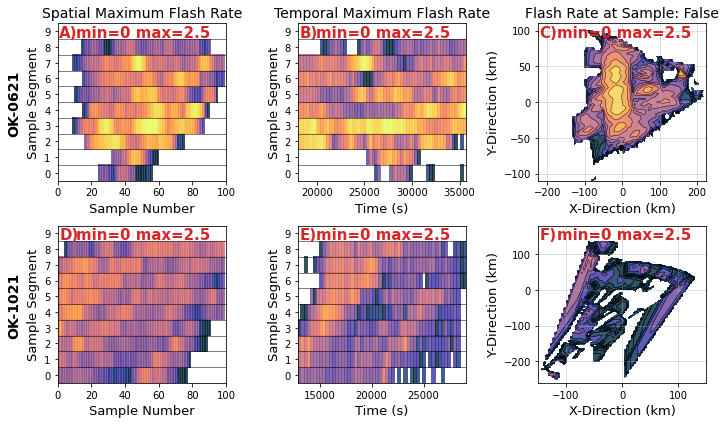

In [22]:
plots.space_time(samps1,flash_field,samps2,flash_field2,xm,ym,xm2,ym2,data1,data2,False)